In [1]:
import getpass
import requests
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import zipfile
from simpledbf import Dbf5
import fiona
import rtree
from collections import OrderedDict
from shapely.geometry import mapping, shape
import matplotlib.pyplot as plt
import shapely.wkb 
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, Point, MultiPolygon


PyTables is not installed. No support for HDF output.


In [2]:
baseFolder = '/home/jovyan/work/datasets'

In [7]:
cell5M_baseline = gpd.read_file(f'{baseFolder}/aqueduct/dst/spam2010/baseline_geo/union_spam_aqueduct_v01.shp')
cell5M_baseline['aq30_id'] = cell5M_baseline['aq30_id'].astype('int64')
cell5M_baseline['Cell5M_ID_'] = cell5M_baseline['Cell5M_ID_'].astype('int')
cell5M_baseline.head()

,FID_April_,alloc_key,Cell5M_ID_,ISO3CODE,FID_baseli,aq30_id,string_id,geometry
0,0,16070037,6937956.0,NZL,-1,0,None,"POLYGON ((-176.91667 -43.91667, -177.00000 -43..."
1,1,16070038,6937957.0,NZL,-1,0,None,"POLYGON ((-176.87876 -43.83341, -176.87991 -43..."
2,2,16060038,6933637.0,NZL,-1,0,None,"POLYGON ((-176.83334 -43.78826, -176.83738 -43..."
3,3,16070039,6937958.0,NZL,-1,0,None,"POLYGON ((-176.83333 -43.91667, -176.83350 -43..."
4,4,16060039,6933638.0,NZL,-1,0,None,"MULTIPOLYGON (((-176.75000 -43.75000, -176.750..."


In [3]:
cell5M_projected = gpd.read_file(f'{baseFolder}/aqueduct/dst/spam2010/cell5m_projected/cell5m_projected.shp')
cell5M_projected['basinid'] = cell5M_projected['basinid'].astype('int64')
cell5M_projected['percentage'] = cell5M_projected['percentage'].astype('float64')
cell5M_projected['percentage'] = cell5M_projected['percentage'].apply(lambda x: round(x,4))
cell5M_projected['cell5m'] = cell5M_projected['cell5m'].astype('int')
cell5M_projected.head()

,basinid,percentage,cell5m,geometry
0,2650,0.0233,478313,"POLYGON ((79.49431 80.83333, 79.41667 80.82917..."
1,7718,0.0024,512301,"POLYGON ((31.83333 80.08338, 31.83241 80.08333..."
2,7271,0.0030,978784,"POLYGON ((25.39330 71.08333, 25.39972 71.08582..."
3,7271,0.0752,978785,"POLYGON ((25.46430 71.08333, 25.47238 71.10228..."
4,7271,0.0625,978786,"POLYGON ((25.50000 71.09664, 25.56520 71.08333..."


In [4]:
df_filtered = pd.read_csv(f'{baseFolder}/aqueduct/dst/spam2010/data_filtered.csv')
df_filtered.drop(columns=['Unnamed: 0'], inplace=True)
gdf_filtered = gpd.GeoDataFrame(df_filtered)
gdf_filtered['cell5m'] = gdf_filtered['cell5m'].astype('int')
gdf_filtered.head()

,iso,prod_level,cell5m,name_cntr,name_adm1,name_adm2,unit_area,crop,area,irrigation,unit_prod,prod
0,AFG,AF01002,2677088,Afghanistan,Badakhshan,Darwaz,ha,wheat,115.6,irrigated,mt,180.4
1,AFG,AF01002,2677090,Afghanistan,Badakhshan,Darwaz,ha,wheat,120.7,irrigated,mt,190.5
2,AFG,AF01002,2677093,Afghanistan,Badakhshan,Darwaz,ha,wheat,180.3,irrigated,mt,237.9
3,AFG,AF01002,2681407,Afghanistan,Badakhshan,Darwaz,ha,wheat,104.1,irrigated,mt,187.1
4,AFG,AF01002,2681409,Afghanistan,Badakhshan,Darwaz,ha,wheat,43.2,irrigated,mt,27.9


In [5]:
filter_geom_ids= gdf_filtered.cell5m.unique()

In [6]:
cell5M_baseline_filtered = cell5M_projected[cell5M_projected['cell5m'].isin(filter_geom_ids)]

In [7]:
cell5M_baseline_filtered.head()

,basinid,percentage,cell5m,geometry
83,7907,0.3352,2223099,"POLYGON ((38.30759 47.13228, 38.26587 47.13044..."
84,7796,0.0942,2223099,"POLYGON ((38.33333 47.13340, 38.30759 47.13228..."
85,7908,0.2427,2223100,"POLYGON ((38.41667 47.14139, 38.40386 47.13361..."
86,7796,0.1445,2223100,"POLYGON ((38.37496 47.16667, 38.37172 47.15787..."
127,3334,0.0007,2842070,"POLYGON ((139.17114 35.25000, 139.16667 35.247..."


In [8]:
cell5M_baseline_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 971248 entries, 83 to 2863959
Data columns (total 4 columns):
basinid       971248 non-null int64
percentage    971248 non-null float64
cell5m        971248 non-null int64
geometry      971248 non-null geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 37.1 MB


In [70]:
def fx(x):
    return x.area

In [71]:
cell5M_baseline_filtered['area_phys']= cell5M_baseline_filtered['geometry'].to_crs({'init': 'epsg:4326'}).apply(lambda x: fx(x)).round(8)
#cell5M_baseline_filtered['percentage']= cell5M_baseline_filtered.to_crs({'init': 'epsg:3395'})['geometry'].area/86056000

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


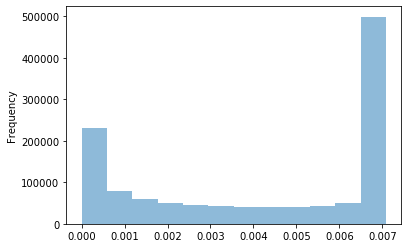

In [72]:

cell5M_baseline_filtered['perrcentage'].plot.hist(bins=12, alpha=0.5)

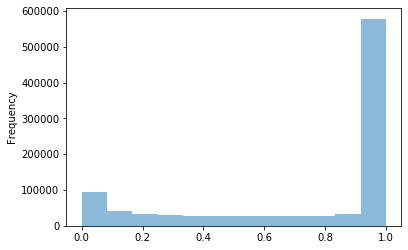

In [9]:
cell5M_baseline_filtered['percentage'].plot.hist(bins=12, alpha=0.5)

In [77]:
def fx2(x):
    return  x/0.0068 if x/0.0068 < 1 else 1
cell5M_baseline_filtered['percentage']= cell5M_baseline_filtered['area_phys'].apply(lambda x: fx2(x)).round(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


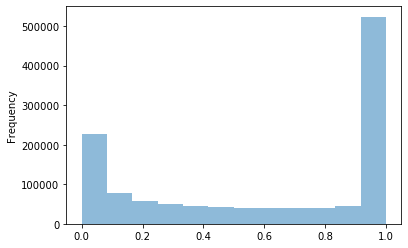

In [78]:
cell5M_baseline_filtered['percentage'].plot.hist(bins=12, alpha=0.5)

In [79]:
cell5M_baseline_filtered.sort_values(by='area_phys', ascending=False)

,FID_April_,alloc_key,cell5m,ISO3CODE,FID_baseli,aq30_id,string_id,geometry,area,percentage,area_phys
720171,280064,06360961,2744160,USA,54370,54370,742485-USA.17_1-1363,"POLYGON ((-99.91667 36.99896, -100.00141 36.99...",11002.711280,1.0,0.007087
1937300,1102228,06962310,3004709,LBY,10180,10180,156040-LBY.3_1-3330,"POLYGON ((12.50040 32.00473, 12.49991 31.99889...",10340.434731,1.0,0.007073
2432027,1724733,09113372,3934571,THA,33791,33791,443040-THA.26_1-2021,"POLYGON ((101.00000 14.16667, 101.00000 14.083...",9032.190017,1.0,0.007068
189028,819882,14981420,6468459,ARG,49708,49708,651206-ARG.1_1-2939,"POLYGON ((-61.66667 -34.75000, -61.66565 -34.8...",10663.161136,1.0,0.007067
1344823,267750,05410858,2333657,USA,55056,55056,742988-USA.51_1-1048,"POLYGON ((-108.49896 45.00082, -108.50000 44.9...",12372.588493,1.0,0.007065
...,...,...,...,...,...,...,...,...,...,...,...
595660,2259148,14973971,6466690,AUS,42695,42695,563950-None-None,"POLYGON ((150.86943 -34.67429, 150.87000 -34.6...",2.127270,0.0,0.000001
2576037,1843249,06423676,2772795,KOR,64817,64817,None-KOR.3_1-None,"POLYGON ((126.33082 36.50048, 126.32931 36.500...",2.016681,0.0,0.000001
472140,2174212,11683738,5045177,IDN,64537,64545,None-IDN.19_1-2566,"POLYGON ((131.44333 -7.33333, 131.44138 -7.333...",1.597822,0.0,0.000001
1588834,514983,05211383,2247782,CAN,53485,53485,726071-None-1194,"POLYGON ((-64.80386 46.66656, -64.80482 46.665...",2.214194,0.0,0.000001


In [36]:
cell5M_baseline_filtered.rename(columns={"Cell5M_ID_": "cell5m"}, inplace=True)
cell5M_baseline_filtered.head(2)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,FID_April_,alloc_key,cell5m,ISO3CODE,FID_baseli,aq30_id,string_id,geometry,area,percentage
143,144,13160060,5680859,TON,-1,0,None,"POLYGON ((-174.99998 -19.66302, -175.00333 -19...",8543.279892,0.992758
147,148,13060065,5637664,TON,-1,0,None,"POLYGON ((-174.66667 -18.83333, -174.66651 -18...",7090.271421,0.823914


In [83]:
cell5M_baseline_filtered.drop(columns=['area', 'area_phys'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
cell5M_baseline_merged = pd.merge(left=gdf_filtered, right=cell5M_baseline_filtered, how='left',left_on=['cell5m'], right_on = ['cell5m'] )

In [11]:
cell5M_baseline_merged.columns

Index(['iso', 'prod_level', 'cell5m', 'name_cntr', 'name_adm1', 'name_adm2',
       'unit_area', 'crop', 'area', 'irrigation', 'unit_prod', 'prod',
       'basinid', 'percentage', 'geometry'],
      dtype='object')

In [12]:
cell5M_baseline_merged.head(2)

,iso,prod_level,cell5m,name_cntr,name_adm1,name_adm2,unit_area,crop,area,irrigation,unit_prod,prod,basinid,percentage,geometry
0,AFG,AF01002,2677088,Afghanistan,Badakhshan,Darwaz,ha,wheat,115.6,irrigated,mt,180.4,6726.0,0.9118,"POLYGON ((70.66667 38.37037, 70.67670 38.37492..."
1,AFG,AF01002,2677088,Afghanistan,Badakhshan,Darwaz,ha,wheat,115.6,irrigated,mt,180.4,6726.0,0.0882,"POLYGON ((70.70842 38.41667, 70.68331 38.41458..."


In [13]:
# Multiply the area and the production with the percentage of each cell fraction
def f(*x):
    return x[0]*x[1]
cell5M_baseline_merged['prod'] = cell5M_baseline_merged[['prod','percentage']].apply(lambda x: f(*x), axis=1).round(1)
cell5M_baseline_merged['area'] = cell5M_baseline_merged[['area','percentage']].apply(lambda x: f(*x), axis=1).round(1)
cell5M_baseline_merged.drop(columns=['percentage'], inplace=True)
# Drop duplicates
cell5M_baseline_merged.drop_duplicates(subset=['cell5m', 'crop', 'irrigation', 'prod', 'basinid'], inplace=True)


In [95]:
cell5M_baseline_merged.to_file(f'{baseFolder}/aqueduct/dst/spam2010/merged_geoms_v1.shp')

In [112]:
cell5M_baseline_filtered.to_file(f'{baseFolder}/aqueduct/dst/spam2010/test_geoms.shp')

In [19]:
cell5M_baseline_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6856351 entries, 0 to 6859975
Data columns (total 14 columns):
iso           object
prod_level    object
cell5m        int64
name_cntr     object
name_adm1     object
name_adm2     object
unit_area     object
crop          object
area          float64
irrigation    object
unit_prod     object
prod          float64
basinid       float64
geometry      geometry
dtypes: float64(3), geometry(1), int64(1), object(9)
memory usage: 784.6+ MB


In [20]:
test_groupbt= cell5M_baseline_merged[['iso','cell5m', 'crop', 'irrigation', 'prod','basinid','geometry']].sort_values(['cell5m','irrigation','prod'], ascending=False).groupby(['cell5m','basinid','irrigation']).first().reset_index()



In [17]:
test_2=cell5M_baseline_merged[['iso','prod_level','cell5m','name_cntr','unit_area','crop','area','irrigation','unit_prod','prod','basinid','geometry']].dissolve(by=['cell5m','basinid','irrigation','crop','iso', 'name_cntr','prod_level'], aggfunc='sum')

In [20]:
test_2=test_2.reset_index()

In [22]:

ranks = test_2[['iso','cell5m', 'crop', 'irrigation', 'prod','basinid','geometry']].groupby(['cell5m','basinid','irrigation'])['prod'].rank(ascending = False, method = 'first')
ranks.name = 'rank'
rank_projected = gpd.GeoDataFrame(pd.concat([test_2, ranks], axis = 1))

#rank_projected.drop(columns=['name_adm1','name_adm2'], inplace=True)
#dataset_forRanks.groupby([['cell5m','basinid','irrigation']]).sum()



rank_projected.head(3)

,cell5m,basinid,irrigation,crop,iso,name_cntr,prod_level,geometry,area,prod,rank
0,1069608,7260.0,rainfed,potato,RUS,Russian Federation,RS50001,"POLYGON ((34.08333 69.35162, 34.02720 69.35360...",29.7,351.6,1.0
1,1069609,7260.0,rainfed,potato,RUS,Russian Federation,RS50001,"POLYGON ((34.16667 69.34869, 34.08333 69.35162...",57.1,675.1,1.0
2,1069609,7260.0,rainfed,vegetables,RUS,Russian Federation,RS50001,"POLYGON ((34.16667 69.34869, 34.08333 69.35162...",3.8,31.8,2.0


In [26]:
rank_projected['unit_area']='ha'
rank_projected['unit_prod']='mt'
rank_projected['basinid'] = rank_projected['basinid'].astype('int')
rank_projected['rank'] = rank_projected['rank'].astype('int')

In [28]:
rank_projected.to_file(f'{baseFolder}/aqueduct/dst/spam2010/allcrops_projected/allCrops_v1.shp')

In [33]:
def split_table(gdf, filename, size):
    """
    this function splits a table in x datasets to make it uploable to a carto account
    """
    dataset = gdf
    for i in range(int(np.ceil(dataset.shape[0]/size))):
        split_dataset_name = filename+'_'+str(i)
        print(split_dataset_name)
        os.mkdir(f'{baseFolder}/aqueduct/dst/spam2010/allcrops_projected/{split_dataset_name}')
        full_path = f'{baseFolder}/aqueduct/dst/spam2010/allcrops_projected/{split_dataset_name}.shp'
        dataset.iloc[i*size:(i+1)*size].to_file(full_path)

In [34]:
basefile =f'{baseFolder}/data/aqueduct/dst/spam2010/allcrops_projected/'
split_table(rank_projected, 'allCrops_v1', 2000000)

allCrops_v1_0
allCrops_v1_1
allCrops_v1_2
allCrops_v1_3


In [ ]:
gpd.GeoDataFrame(test_groupbt).to_file(f'{baseFolder}/aqueduct/dst/spam2010/merged_allCrops_v1.shp')

In [115]:
gpd.GeoDataFrame(test_groupbt).to_file(f'{baseFolder}/aqueduct/dst/spam2010/merged_allCrops_v1.shp')

In [117]:
test_group_all= cell5M_baseline_merged[['iso','cell5m', 'crop', 'irrigation', 'prod','aq30_id','geometry']].sort_values(['cell5m','irrigation','prod'], ascending=False).groupby(['cell5m','aq30_id','crop', 'geometry']).sum().reset_index()
test_group_all.head(10)

TypeError: '<' not supported between instances of 'Polygon' and 'Polygon'